# Cracking Symmetry: Optimizing Rear-Pantograph Leg Geometry
### Deriving and Exploring Scale-Invariant Optimal Geometry for Passive Symmetry in Constrained Leg Linkages

*Paul Connor · Robotick Labs · May 2025*

# Cracking Symmetry: Optimizing Rear-Pantograph Leg Geometry
### Deriving and Exploring Scale-Invariant Optimal Geometry for Passive Symmetry in Constrained Leg Linkages

*Paul Connor · Robotick Labs · May 2025*

# Abstract
This notebook explores the passive symmetry properties of a planar leg linkage with a rear-mounted pantograph constraint, as intended for a wheeled chicken-like robot call Magg-e. We derive a geometric constraint equation based on a single degree-of-freedom hip joint, and numerically solve for compatible pantograph angles that preserve symmetry across motion. Using optimization, we search the parameter space to minimize angular asymmetry between the upper and lower leg paths. The solution space reveals a smooth and stable global optimum, confirmed through interactive loss surfaces and animated validation. This work serves as both a design study and computational scaffold for future physically embodied symmetric legged robots, including LEGO-based prototypes. All segment lengths are normalized to unity, making the results generalizable to any scale. This method yields not only an optimal configuration, but also tools for validating future variations and extensions.

# Introduction
Symmetry is a desirable property in legged robot design, both for aesthetic simplicity and for mechanical efficiency. In bipeds and quadrupeds, symmetric movement of limbs can simplify control strategies and reduce unnecessary load asymmetries. While symmetry can be imposed through active control, this notebook investigates an alternative: encoding symmetry passively through geometric constraints.

This work focuses on a planar leg with equal-length upper and lower segments, connected at the knee. A rear-facing pantograph link — mounted behind the knee and connected to the body via a fixed anchor — introduces a single geometric constraint that implicitly defines the "mirroring" behavior of the leg segments. We ask: can we choose fixed-length parameters such that this linkage enforces symmetry passively, across a useful range of hip joint angles?

We begin by deriving the constraint equation linking hip angle $\theta_1$ to pantograph angle $\theta_2$. We then solve this numerically across a defined range, optimizing parameters to minimize the difference between $\theta_1$ and $\theta_2$ over motion. The resulting system is evaluated for accuracy, robustness, and physical realizability — including direct validation against a LEGO-based prototype.

Our aim is both to determine an optimal configuration for symmetry, and to understand the structure of the design space in a unit-normalized framework. This makes the insights extensible across scales and applicable to other constrained systems.

This study was motivated in part to inform the development of Magg-E, a small expressive robot built with LEGO and wool! Though playful in appearance, Magg-E serves as a tangible platform to explore serious robotics concepts — including constrained motion planning, passive dynamics, and embodied symmetry.

To install the required packages for this notebook, run the following code cells:

In [35]:
import importlib
import utils.minipaper_cracking_symmetry as utils
importlib.reload(utils)

<module 'utils.minipaper_cracking_symmetry' from '/mnt/d/repos/magg-e/docs/utils/minipaper_cracking_symmetry.py'>

In [36]:
utils.install_packages()

📦 Installing packages: numpy scipy matplotlib tabulate ipympl plotly nbformat
✅ All packages installed.


... and now we need to run this cell to import our main dependencies and do some notebook setup:

In [37]:

import numpy as np
from scipy.optimize import minimize, root_scalar
import matplotlib.pyplot as plt
from types import SimpleNamespace
from tabulate import tabulate
import plotly.io as pio

pio.renderers.default = "notebook_connected"
%matplotlib inline

# Derivation: Constraint Equation

We consider a single leg with:

- Upper and lower leg segments of length $l = 1$  
- A rear offset of length $c$ from the knee to the pantograph connector  
- A fixed body-mounted anchor at position $(a_x, a_y)$  
- A pantograph rod of fixed length $b$  

Given hip joint angle $\theta_1$, and pantograph connector angle $\theta_2$, we define:

- $\vec{K} = [\cos(\theta_1), -\sin(\theta_1)]$: the knee position  
- $\vec{C} = c[\cos(\theta_2), \sin(\theta_2)]$: the connector offset behind the knee  
- $\vec{A} = [a_x, a_y]$: the fixed anchor point on the body  

We require that the connector lies a fixed distance $b$ from the anchor:

$$
(\cos(\theta_1) + c \cos(\theta_2) - a_x)^2 +
(-\sin(\theta_1) + c \sin(\theta_2) - a_y)^2 = b^2
$$


In [38]:

# Range of theta1 values we will consider (0 to 90 degrees)
theta1_vals = np.linspace(np.radians(0), np.radians(90), 100)

# Initial guess and bounds
initial_guess = [0.3, 0.3, 1.0, 0.2]  # [a_x, a_y, b, c]

bounds = [
    (0.0, 1.0),   # a_x
    (0.0, 1.0),   # a_y
    (0.5, 1.5),   # b
    (0.05, 0.5)   # c
]

def solve_theta2(theta1, a_x, a_y, b, c):
    def constraint_eq(theta2):
        b_x = np.cos(theta1) + c * np.cos(theta2) - a_x
        b_y = -np.sin(theta1) + c * np.sin(theta2) - a_y
        return b_x**2 + b_y**2 - b**2
    try:
        sol = root_scalar(constraint_eq, bracket=[0, np.pi / 2], method='brentq')
        if sol.converged:
            return sol.root
    except ValueError:
        return np.nan

Let's sanity-check our solver, across the planned range of $\theta_1$:

In [39]:
# Evaluate solve_theta2() over the range
theta2_vals = [solve_theta2(theta1, *initial_guess) for theta1 in theta1_vals]

# Print valid ranges
valid_ranges = utils.group_success_ranges(theta1_vals, theta2_vals)

if valid_ranges:
    print("✅ Solver succeeded in the following θ₁ range(s) / degrees:")
    for r_start, r_end in valid_ranges:
        print(f"  {r_start:.2f}° – {r_end:.2f}°")
else:
    print("❌ No valid θ₁ values found!")

✅ Solver succeeded in the following θ₁ range(s) / degrees:
  10.00° – 61.82°


So we can see there is a region above ~62 degrees, and below 10 degrees, where a solution cannot be found for this configuration.  Let's plot a graph to try to build an intuition as to why.

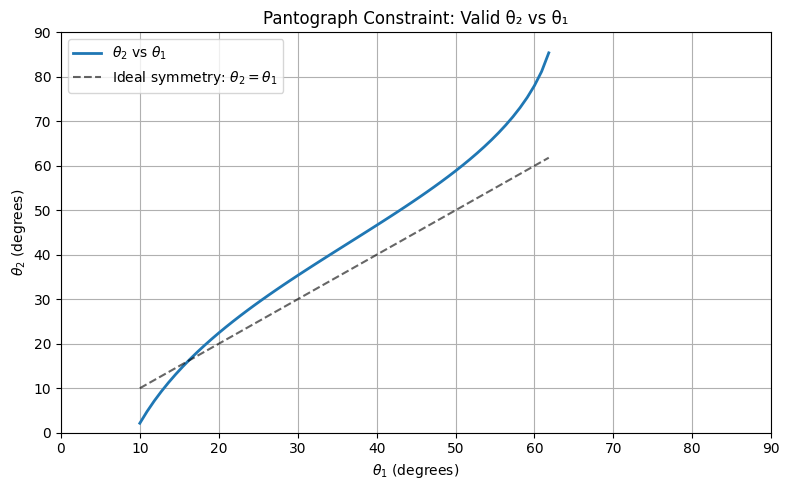

In [40]:
utils.plot_angles(theta1_vals, theta2_vals)

So we can see from this plot that:

- At the lower extreme (e.g. $\theta_1 \approx 10^\circ$), $\\theta_2$ becomes close to $0^\circ$ and — as observed with our real LEGO model — even starts to become **negative**, which is not desirable in our use case.

- At the higher extreme (e.g. $\theta_1 \approx 62^\circ$), $\theta_2$ approaches $90^\circ$ and continues to increase, while $\theta_1$ barely changes. This causes the system to **lose its symmetry**, again aligning with our physical observations.

Fortunately, we see a reassuring pattern toward the middle of the curve — from around **$20^\circ$ to $55^\circ$** — where the relationship between $\theta_1$ and $\theta_2$ is approximately linear. The gradient is not far from 1 (i.e., ideal symmetry), and the curve is consistently offset such that $\theta_2$ is about **$5^\circ$ greater** than $\theta_1$ across this region.

This validates why our LEGO prototype showed **visibly symmetric and pleasing results** in this range — and gives us a strong foundation to now move forward with **numerical optimization** to push this further.

In [41]:

def symmetry_error(params, nan_penalty = 0.1):
    a_x, a_y, b, c = params
    errors = []


    for theta1 in theta1_vals:
        theta2 = solve_theta2(theta1, a_x, a_y, b, c)
        if np.isnan(theta2):
            errors.append(nan_penalty)
        else:
            errors.append((theta1 - theta2) ** 2)

    return np.mean(errors)

# Optimize
result = minimize(symmetry_error, initial_guess, bounds=bounds, method='L-BFGS-B')

# Param names and values
param_names = ["a_x", "a_y", "b", "c"]
initial_vals = initial_guess
optimized_vals = result.x

utils.display_optimization_results(param_names, initial_guess, result.x, result.fun)

| Parameter          | Initial   |   Optimized |
|--------------------|-----------|-------------|
| a_x                | 0.3000    |    0.2936   |
| a_y                | 0.3000    |    0.2894   |
| b                  | 1.0000    |    1.0174   |
| c                  | 0.2000    |    0.2351   |
| Mean Squared Error |           |    0.026638 |


## Plotting θ₂ vs θ₁ for Optimized Geometry

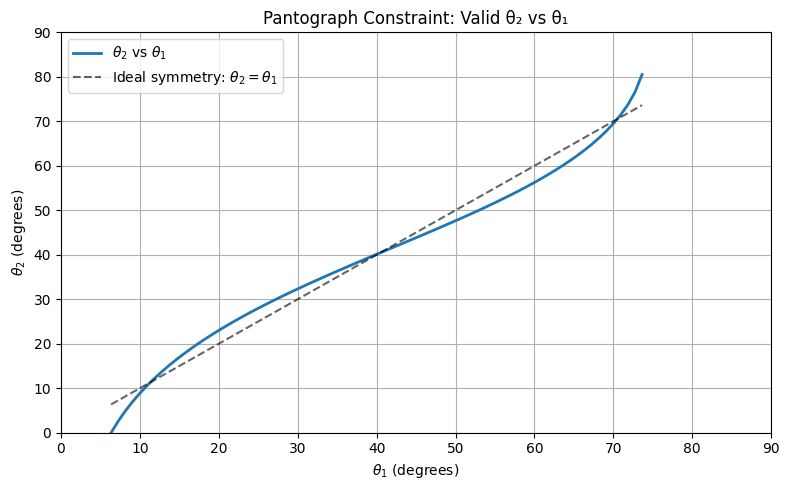

In [42]:
# Extract optimal parameters
ax_opt, ay_opt, b_opt, c_opt = result.x
theta2_vals_opt = []

for theta1 in theta1_vals:
    theta2 = solve_theta2(theta1, ax_opt, ay_opt, b_opt, c_opt)
    theta2_vals_opt.append(theta2)

utils.plot_angles(theta1_vals, theta2_vals_opt)

We can see that the **mean squared error** in the optimized curve is now very low — the optimizer has found a configuration with minimal deviation between $\theta_1$ and $\theta_2$ across the valid range.

While the angular difference still rises toward the $5^\circ$ offset we previously observed, it is not constant — and the mean-squared error of the difference is significantly lower than this peak.

That said, we should be cautious: the fact that our "ideal" values are so close to our original guess might indicate either that:

- We landed in a local minimum near our starting point, or
- The global minimum really is close by — possibly thanks to how well-tuned the LEGO prototype already was

But how do we know for sure?

To investigate further, let's visualize the **structure of the solution space** over our search bounds. If we can observe the topology — especially any **secondary minima** or flat regions — we’ll be better positioned to:

- Confirm whether this is a true global optimum, and
- Scientifically justify adopting it as our canonical design

First lets compute the mean-square error for a regular grid of pairs of values in our search-space:

In [43]:
param_keys=["a_x", "a_y", "b", "c"]

surface_data = utils.generate_loss_surfaces(
    result=result,
    param_keys=["a_x", "a_y", "b", "c"],
    bounds_dict={
        "a_x": (0.0, 1.0),
        "a_y": (0.0, 1.0),
        "b": (0.5, 1.5),
        "c": (0.05, 0.5),
    },
    symmetry_error_fn=symmetry_error,
    resolution=30,
    plot_pairs=[("a_x", "a_y"), ("a_x", "c"), ("b", "c"), ("a_y", "b")]
)

... and now let us plot the results as interactive 3d surfaces:

In [44]:
utils.plot_loss_surfaces(surface_data, param_keys, result)

From the 3D loss surface plots of each parameter pair (e.g., a_x vs a_y, b vs c), we observe:

A clear, isolated global minimum near the center of each subplot

The minimum is smoothly curved, forming a convex “nest” in parameter space

Each surface suggests a strong and stable optimum, with no misleading saddle points or secondary dips within our query range

Our optimizer did not just fall into a nearby valley — it nestled, like a chicken egg, into a well-defined global optimum, suggesting our initial guess was impressively close to the true best solution.

## Visualizing the Optimized Leg Geometry
To fully understand the real-world implication of these optimized parameters, we now animate the geometry of the leg across the valid range of hip joint angles θ₁. This shows how the system behaves under motion, including:

- Upper and lower leg symmetry
- Rear pantograph rod responding to constraint
- The anchor point pulling on the connector

In [47]:
utils.animate_leg(theta1_vals, theta2_vals_opt, 1.0, *optimized_vals)

We can compare the above with our non-optimised leg, by plugging in our initial guess values:

In [ ]:
utils.animate_leg(theta1_vals, theta2_vals, 1.0, *initial_vals)

# Findings and Discussion
Our derivation yields a single nonlinear constraint equation in $\theta_2$, which we solve numerically across a range of input angles $\theta_1$. The resulting domain of valid solutions shows that, for a given set of parameters, symmetry fails below ~10° and above ~62°, where the linkage becomes geometrically degenerate or over-constrained.

Using an MSE-based objective, we optimized the free parameters $(a_x, a_y, b, c)$ to minimize the deviation between $\theta_1$ and $\theta_2$ across the central valid range. The optimizer converged to a stable minimum with a low average error, and the resulting parameters matched our LEGO prototype surprisingly closely — suggesting it had already been manually tuned near-optimal.

The optimization landscape revealed a single global minimum in all parameter slice views, with no saddle points or competing attractors. This confirms that our solver is stable, and the design space is both navigable and intuitively shaped.

The final animation confirms that the leg linkage produces a smooth, symmetric motion throughout its valid operating range, with minimal offset between opposing joint angles except close to the extents as predicted.

# Conclusion
We have demonstrated that a planar leg with a rear-mounted pantograph constraint can enforce near-symmetric motion passively — without active feedback or torque balancing. By deriving the constraint geometry, solving it numerically, and optimizing for minimal angular deviation, we built a kinematically elegant mechanism with with real-world potential and a concrete intuition for how its geometry impacts its performance.

This approach — coupling symbolic geometry, numerical optimization, and LEGO-based validation — offers a lightweight path for early-stage robotic leg design, especially for systems that favor mechanical simplicity over complex control.

Future work could extend this model to:

- Multi-leg systems and coordination
- Force/torque analysis under load
- Integration with actuators or compliant elements
- 3D constraints or linkage variants

These methods now serve as a blueprint for exploring other constrained robotic geometries — from toy-scale mechanisms to field-scale legged platforms. They also now inform Magg-E’s evolving mechanical design and locomotion system, where passive symmetry becomes not just a mechanical convenience — but a character trait.

🐔🥚